In [9]:
import warnings
warnings.filterwarnings("ignore")

import re
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.1)
plt.rcParams["figure.dpi"] = 120

RESOURCE_ID = "6222085d-ee88-45c6-ae40-0c7464620d64"
BASE_URL    = "https://data.boston.gov/api/3/action/datastore_search"
BATCH_SIZE  = 10_000
print("Ready.")

Ready.


In [10]:
def fetch_all_records(resource_id: str, batch_size: int = 10_000) -> pd.DataFrame:
    all_records, offset = [], 0
    params = {"resource_id": resource_id, "limit": batch_size, "offset": 0}
    resp = requests.get(BASE_URL, params=params, timeout=60)
    resp.raise_for_status()
    data = resp.json()
    if not data.get("success"):
        raise RuntimeError(f"API error: {data.get('error')}")
    result = data["result"]
    total  = result["total"]
    print(f"Total records: {total:,}")
    all_records.extend(result["records"])
    offset += batch_size
    while offset < total:
        params["offset"] = offset
        batch = requests.get(BASE_URL, params=params, timeout=60).json()["result"]["records"]
        all_records.extend(batch)
        offset += batch_size
        print(f"  Fetched {min(offset, total):,}/{total:,}", end="\r")
    print(f"\nLoaded {len(all_records):,} records.")
    return pd.DataFrame(all_records)

df_raw = fetch_all_records(RESOURCE_ID, BATCH_SIZE)
df_raw.head()

Total records: 26

Loaded 26 records.


,_id,NAME,AD,ZIPCODE,NEIGH,XCOORD,YCOORD,Location
0,1,Lemuel Shattuck Hospital,170 MORTON ST,2130,ROSLINDALE,71106033,42300022,"170 MORTON ST\nROSLINDALE, MA 02130\n(42.30025..."
1,2,Beth Israel Deaconess Medical Center East Cam,330 BROOKLINE AV,2115,FENWAY/KENMORE,71106780,42339726,"330 BROOKLINE AV\nFENWAY/KENMORE, MA 02115\n(4..."
2,3,Jewish Memorial Hospital,59 TOWNSEND ST,2119,ROXBURY,71092712,42318569,"59 TOWNSEND ST\nROXBURY, MA 02119\n(42.3185628..."
3,4,New England Baptist Hospital,125 PARKER HILL AV,2120,JAMAICA PLAIN,71107615,42329944,"125 PARKER HILL AV\nJAMAICA PLAIN, MA 02120\n(..."
4,5,Boston Specialty & Rehabilitation Hospital,249 RIVER ST,2126,MATTAPAN,71081888,42271300,"249 RIVER ST\nMATTAPAN, MA 02126\n(42.27137912..."


In [11]:
## 2 · Feature Engineering & Cleaning

df = df_raw.copy()

# ── NEIGH: normalise mixed casing → Title Case ────────────────────────────────
df["NEIGH"] = df["NEIGH"].astype(str).str.strip().str.title()

# ── ZIPCODE: ensure string, strip whitespace ──────────────────────────────────
df["ZIPCODE"] = df["ZIPCODE"].astype(str).str.strip().str.zfill(5)
# Prepend "0" to make valid 5-digit MA zip (e.g. "2115" → "02115")
df["ZIPCODE"] = df["ZIPCODE"].apply(lambda z: z if len(z) == 5 else "0" + z)

# ── Coordinates: XCOORD/YCOORD are scaled integers (÷1e6 → decimal degrees) ──
# "NULL" string → NaN, then divide
df["XCOORD"] = pd.to_numeric(df["XCOORD"].replace("NULL", np.nan), errors="coerce")
df["YCOORD"] = pd.to_numeric(df["YCOORD"].replace("NULL", np.nan), errors="coerce")
df["Lat"]    = df["YCOORD"] / 1e6   # YCOORD encodes latitude
df["Long"]   = -df["XCOORD"] / 1e6  # XCOORD encodes longitude (stored as positive)

# Sanity check: drop obviously out-of-range Boston coords
df.loc[~df["Lat"].between(42.2, 42.45),  ["Lat", "Long"]] = np.nan
df.loc[~df["Long"].between(-71.25, -70.9), ["Lat", "Long"]] = np.nan

# ── Parse lat/long from Location string as fallback ──────────────────────────
def parse_location_coords(loc_str):
    """Extract (lat, lon) from Location string like '...(42.33, -71.10)'."""
    match = re.search(r"\((-?\d+\.\d+),\s*(-?\d+\.\d+)\)", str(loc_str))
    if match:
        return float(match.group(1)), float(match.group(2))
    return np.nan, np.nan

loc_lat, loc_lon = zip(*df["Location"].apply(parse_location_coords))
df["loc_lat"] = loc_lat
df["loc_lon"] = loc_lon

# Fill missing Lat/Long from Location string
mask = df["Lat"].isna()
df.loc[mask, "Lat"]  = df.loc[mask, "loc_lat"]
df.loc[mask, "Long"] = df.loc[mask, "loc_lon"]
df.drop(columns=["loc_lat", "loc_lon"], inplace=True)

# ── IS_LOCATED flag ───────────────────────────────────────────────────────────
df["IS_LOCATED"] = (~df["Lat"].isna()).astype(int)

print("Shape:", df.shape)
print(f"\nCoordinates resolved: {df['IS_LOCATED'].sum()} / {len(df)}")
display(df[["NAME", "NEIGH", "ZIPCODE", "Lat", "Long", "IS_LOCATED"]].head(10))

Shape: (26, 11)

Coordinates resolved: 26 / 26


,NAME,NEIGH,ZIPCODE,Lat,Long,IS_LOCATED
0,Lemuel Shattuck Hospital,Roslindale,02130,42.300022,-71.106033,1
1,Beth Israel Deaconess Medical Center East Cam,Fenway/Kenmore,02115,42.339726,-71.106780,1
2,Jewish Memorial Hospital,Roxbury,02119,42.318569,-71.092712,1
3,New England Baptist Hospital,Jamaica Plain,02120,42.329944,-71.107615,1
4,Boston Specialty & Rehabilitation Hospital,Mattapan,02126,42.271300,-71.081888,1
5,Boston Medical Center,South End,02118,42.336883,-71.072029,1
6,Va Hospital,Jamaica Plain,02120,42.329944,-71.107615,1
7,Massachusetts Eye & Ear Infirmary,Central,02114,42.361888,-71.071597,1
8,Kindred Hospital,Allston/Brighton,02135,42.344524,-71.143257,1
9,Brigham And Women's Hospital,Fenway/Kenmore,02115,42.336110,-71.108736,1


In [12]:
## 3 · Dataset Overview

print("=" * 60)
print(f"Total hospitals  : {len(df)}")
print(f"Neighbourhoods   : {df['NEIGH'].nunique()}")
print(f"ZIP codes        : {df['ZIPCODE'].nunique()}")
print(f"With coordinates : {df['IS_LOCATED'].sum()} ({df['IS_LOCATED'].mean()*100:.0f}%)")
print("=" * 60)

# Missing value summary
missing     = df[["NAME","AD","ZIPCODE","NEIGH","Lat","Long"]].isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)
overview    = pd.DataFrame({"Missing": missing, "Missing %": missing_pct})
print("\nMissing value summary:")
display(overview[overview["Missing"] > 0])

Total hospitals  : 26
Neighbourhoods   : 10
ZIP codes        : 15
With coordinates : 26 (100%)

Missing value summary:


,Missing,Missing %


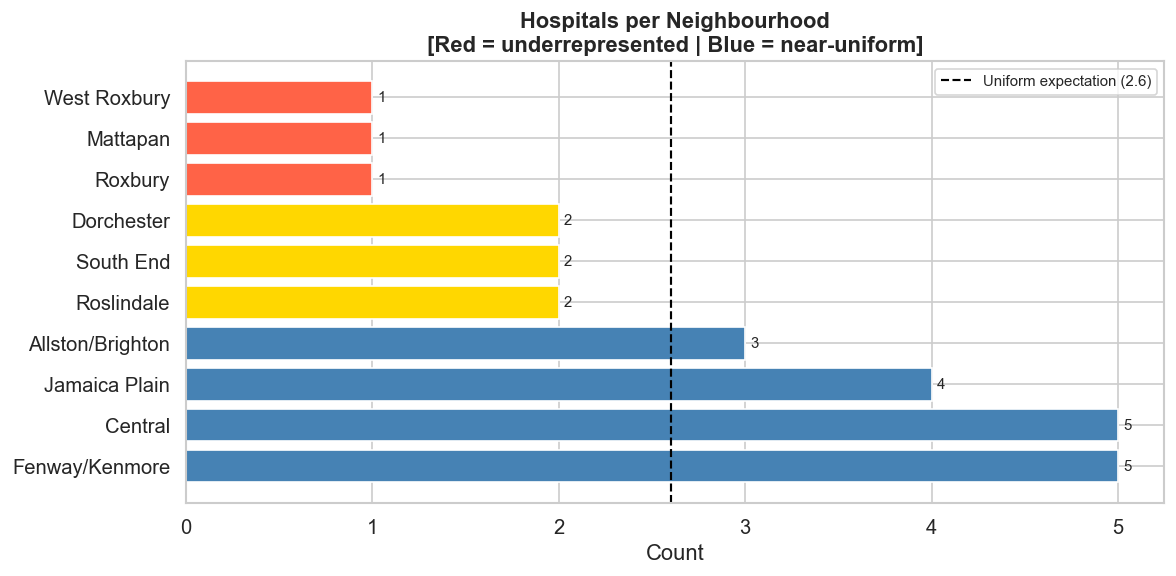


Hospitals per Neighbourhood:


,count,share_pct
NEIGH,,
Fenway/Kenmore,5,19.2
Central,5,19.2
Jamaica Plain,4,15.4
Allston/Brighton,3,11.5
Roslindale,2,7.7
South End,2,7.7
Dorchester,2,7.7
Roxbury,1,3.8
Mattapan,1,3.8


In [13]:
## 4 · Univariate Distributions

# ── Plot 1: Hospitals per Neighbourhood ──────────────────────────────────────
neigh_vc = df["NEIGH"].value_counts()
expected = len(df) / df["NEIGH"].nunique()

fig, ax = plt.subplots(figsize=(10, 5))
colors  = ["tomato" if v < expected * 0.7 else
           "gold"   if v < expected * 0.9 else
           "steelblue" for v in neigh_vc.values]
bars = ax.barh(neigh_vc.index, neigh_vc.values, color=colors, edgecolor="white")
ax.axvline(expected, color="black", linestyle="--", linewidth=1.3,
           label=f"Uniform expectation ({expected:.1f})")
ax.bar_label(bars, padding=3, fontsize=9)
ax.set_title("Hospitals per Neighbourhood\n[Red = underrepresented | Blue = near-uniform]",
             fontweight="bold")
ax.set_xlabel("Count")
ax.legend(fontsize=9)
plt.tight_layout()
plt.show()

print("\nHospitals per Neighbourhood:")
display(neigh_vc.rename("count").to_frame()
        .assign(share_pct=(neigh_vc / len(df) * 100).round(1)))

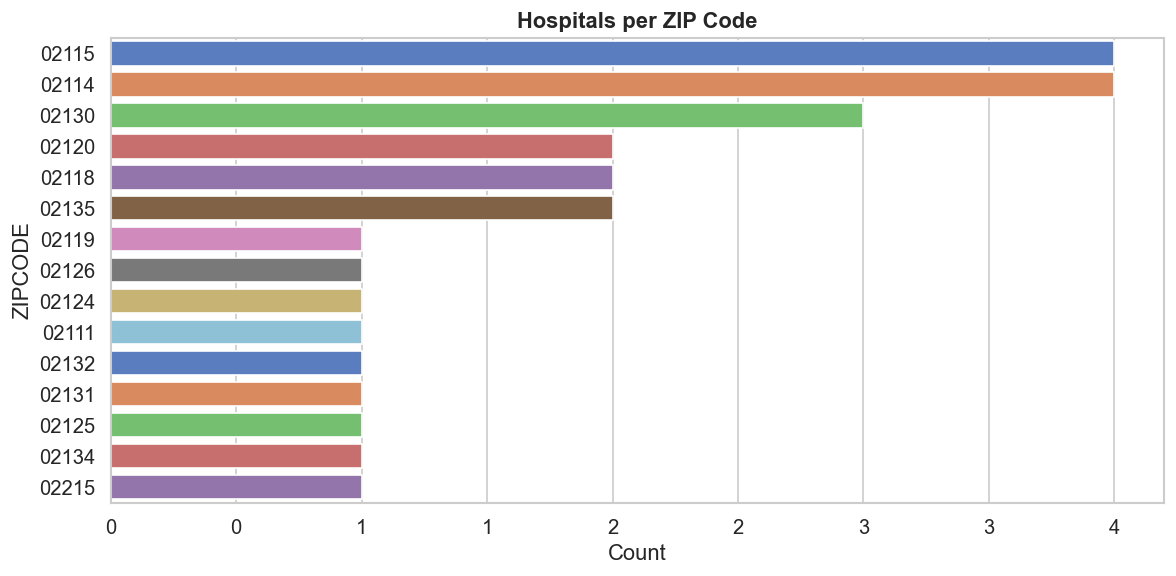

In [14]:

# ── Plot 2: Hospitals per ZIP code ───────────────────────────────────────────
zip_vc = df["ZIPCODE"].value_counts()

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=zip_vc.values, y=zip_vc.index, ax=ax,
            palette=sns.color_palette("muted", len(zip_vc)), orient="h")
ax.set_title("Hospitals per ZIP Code", fontweight="bold")
ax.set_xlabel("Count")
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}"))
plt.tight_layout()
plt.show()

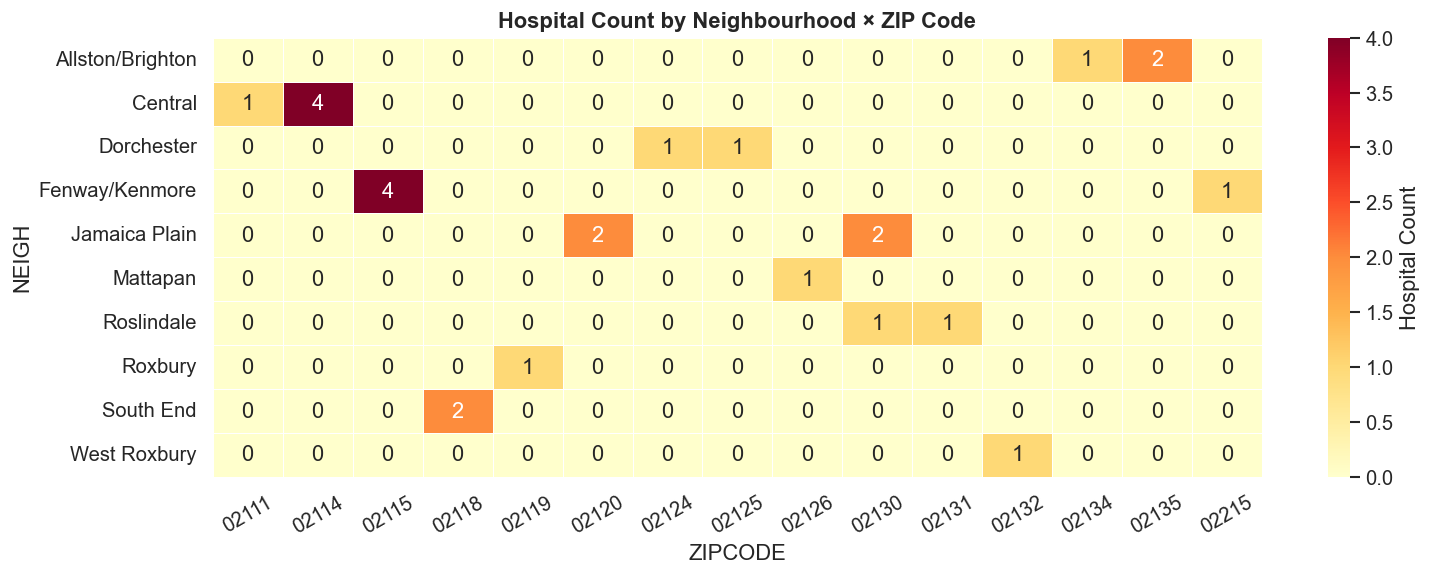

In [15]:
# ── Plot 3: Neighbourhood × ZIP heatmap ──────────────────────────────────────
pivot_nz = (
    df.groupby(["NEIGH", "ZIPCODE"]).size()
      .unstack(fill_value=0)
)
fig, ax = plt.subplots(figsize=(13, 5))
sns.heatmap(pivot_nz, ax=ax, cmap="YlOrRd", annot=True, fmt="d",
            linewidths=0.5, cbar_kws={"label": "Hospital Count"})
ax.set_title("Hospital Count by Neighbourhood × ZIP Code", fontweight="bold")
ax.tick_params(axis="x", rotation=30)
plt.tight_layout()
plt.show()

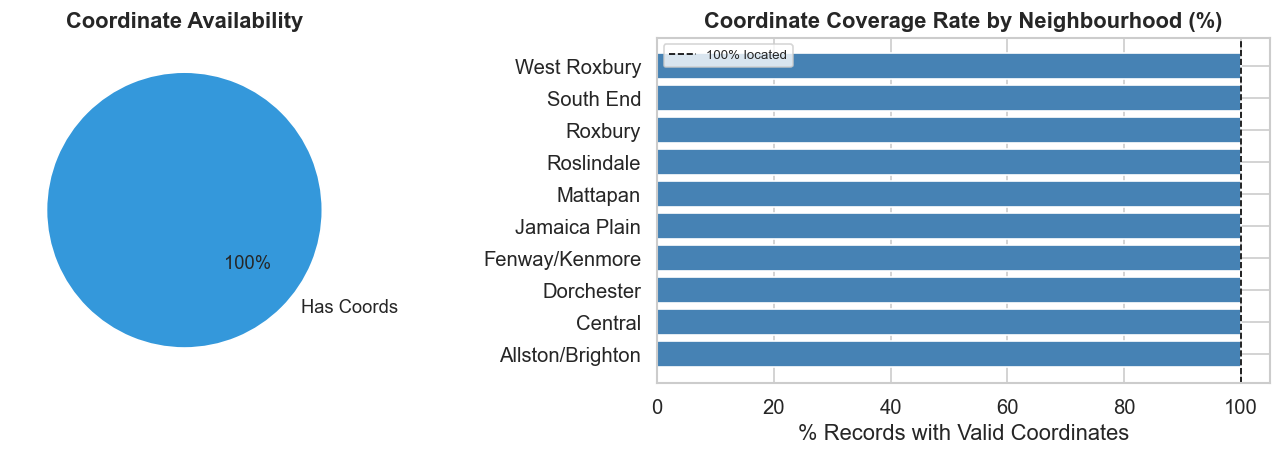

In [16]:
## 5 · Data Quality Analysis

# ── Coordinate availability ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Pie
located = df["IS_LOCATED"].value_counts().rename({1: "Has Coords", 0: "Missing Coords"})
axes[0].pie(located.values, labels=located.index, autopct="%1.0f%%",
            colors=["#3498db", "#e74c3c"], startangle=140,
            textprops={"fontsize": 11})
axes[0].set_title("Coordinate Availability", fontweight="bold")

# Missing coords by neighbourhood
miss_by_neigh = (
    df.groupby("NEIGH")["IS_LOCATED"].mean() * 100
).sort_values()
colors_n = ["tomato" if v < 100 else "steelblue" for v in miss_by_neigh.values]
axes[1].barh(miss_by_neigh.index, miss_by_neigh.values, color=colors_n, edgecolor="white")
axes[1].axvline(100, color="black", linestyle="--", linewidth=1, label="100% located")
axes[1].set_title("Coordinate Coverage Rate by Neighbourhood (%)", fontweight="bold")
axes[1].set_xlabel("% Records with Valid Coordinates")
axes[1].legend(fontsize=8)
plt.tight_layout()
plt.show()


Plotting 26 hospitals with valid coordinates.


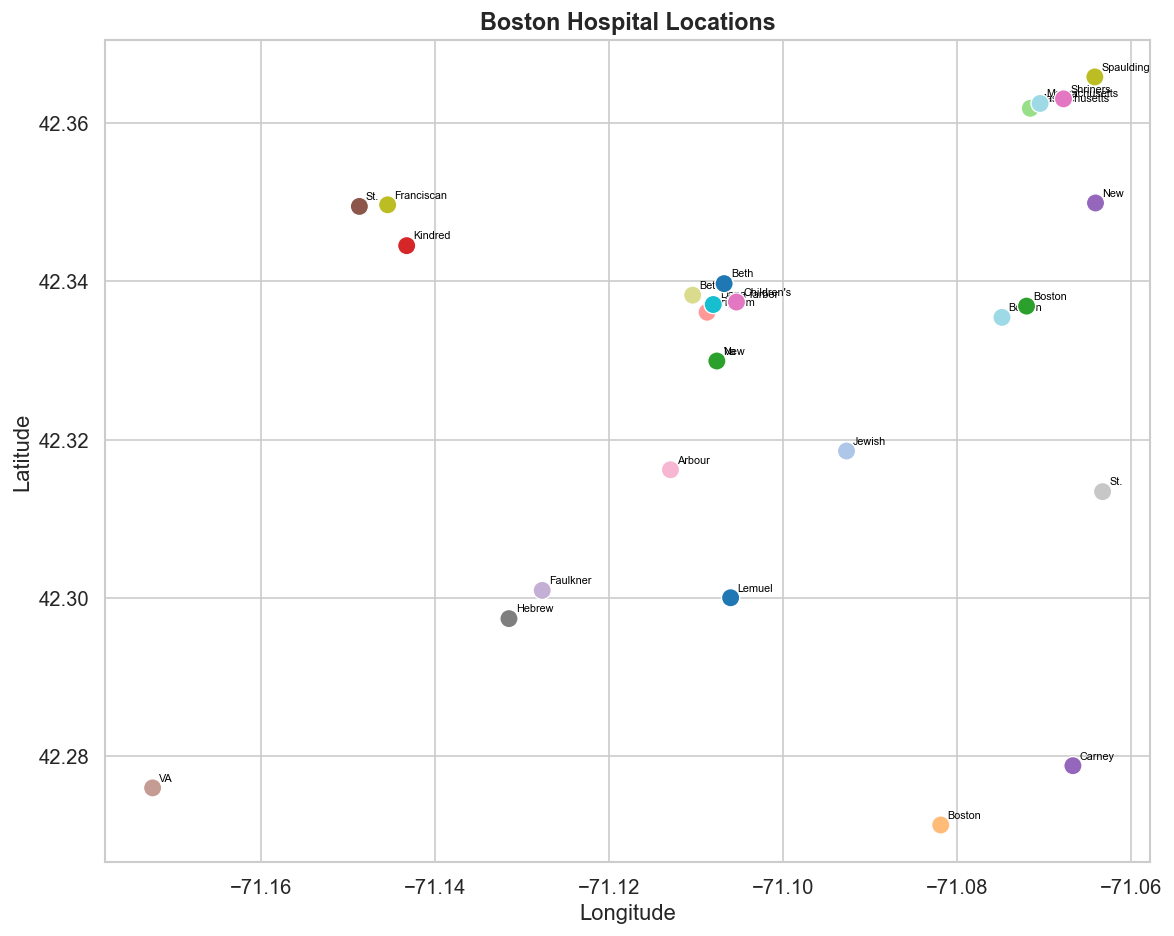

In [17]:
## 6 · Geographic Distribution

geo = df[df["IS_LOCATED"] == 1].copy()
print(f"\nPlotting {len(geo)} hospitals with valid coordinates.")

# ── Plot 1: All hospitals scatter ─────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(geo["Long"], geo["Lat"],
                     s=120, zorder=5, edgecolors="white", linewidths=0.8,
                     c=range(len(geo)), cmap="tab20")
for _, row in geo.iterrows():
    ax.annotate(row["NAME"].split(" ")[0],          # first word as short label
                xy=(row["Long"], row["Lat"]),
                xytext=(4, 4), textcoords="offset points",
                fontsize=6.5, color="black")
ax.set_title("Boston Hospital Locations", fontweight="bold", fontsize=14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

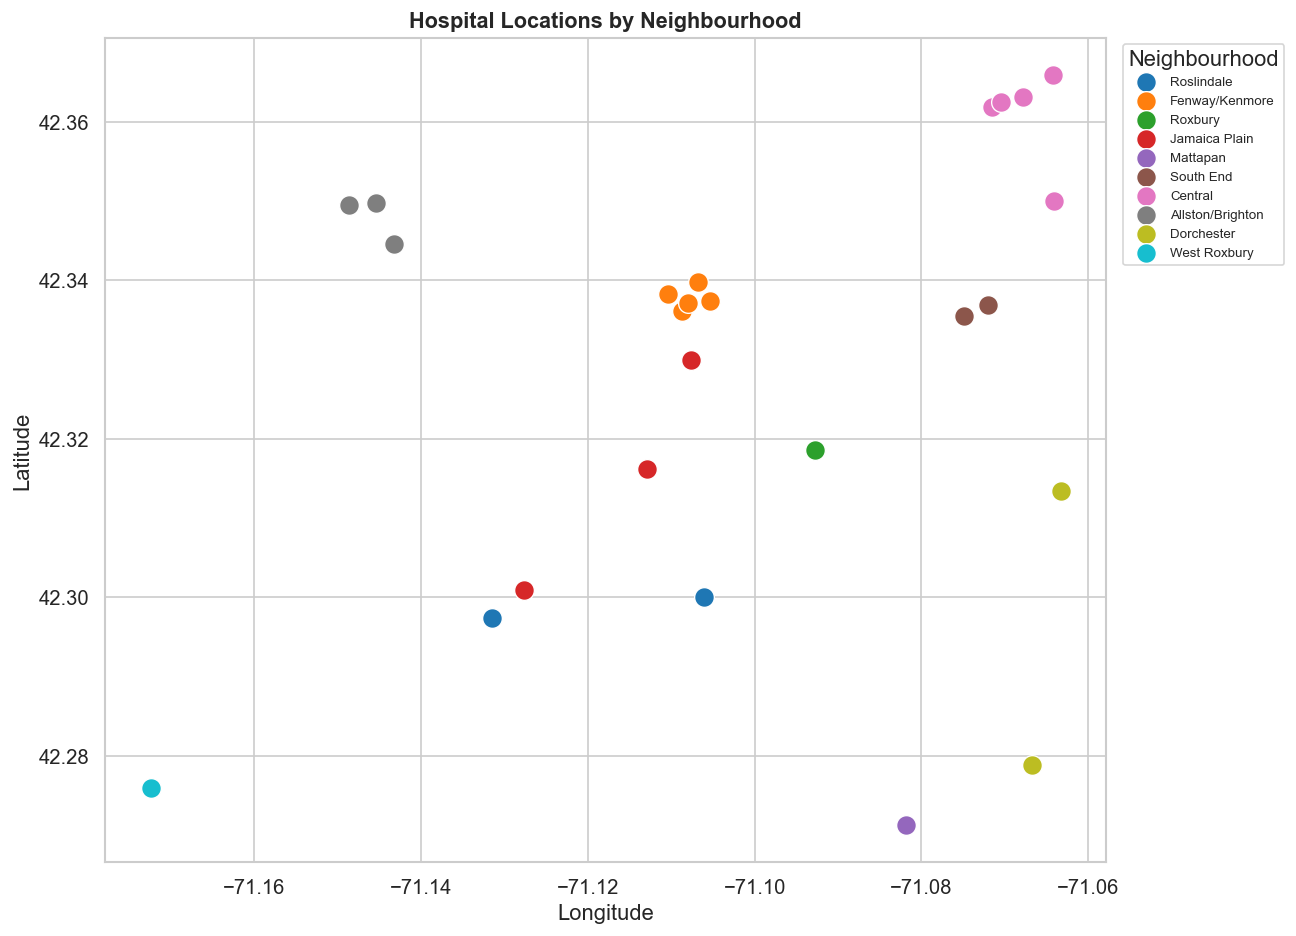

In [18]:
# ── Plot 2: Hospitals coloured by Neighbourhood ───────────────────────────────
neighs    = geo["NEIGH"].unique()
cmap_n    = plt.cm.get_cmap("tab10", len(neighs))
neigh_map = {n: i for i, n in enumerate(neighs)}

fig, ax = plt.subplots(figsize=(11, 8))
for neigh in neighs:
    sub = geo[geo["NEIGH"] == neigh]
    ax.scatter(sub["Long"], sub["Lat"],
               s=140, label=neigh, edgecolors="white", linewidths=0.8,
               color=cmap_n(neigh_map[neigh]), zorder=5)
ax.set_title("Hospital Locations by Neighbourhood", fontweight="bold", fontsize=13)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(title="Neighbourhood", bbox_to_anchor=(1.01, 1), fontsize=8)
plt.tight_layout()
plt.show()


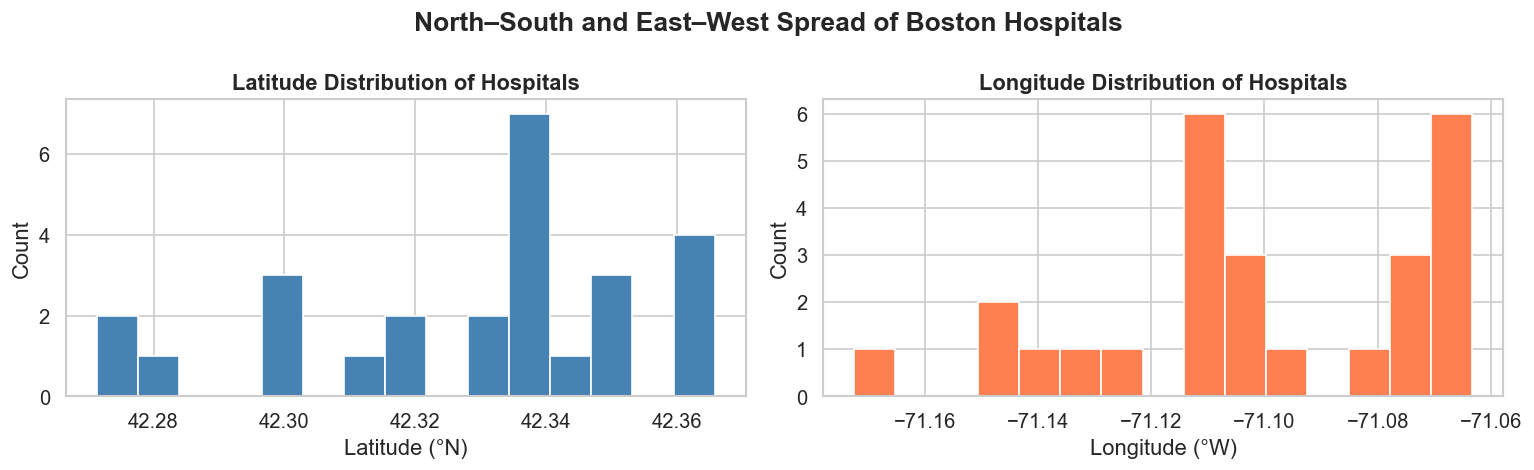


Coordinate summary stats:


,Lat,Long
count,26.00000,26.00000
mean,42.32848,-71.10124
std,0.02723,0.03063
min,42.27130,-71.17245
25%,42.31413,-71.11231
50%,42.33650,-71.10641
75%,42.34824,-71.07170
max,42.36585,-71.06329


In [19]:
# ── Plot 3: Longitude & Latitude marginal distributions ──────────────────────
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
axes[0].hist(geo["Lat"],  bins=15, color="steelblue", edgecolor="white")
axes[0].set_title("Latitude Distribution of Hospitals", fontweight="bold")
axes[0].set_xlabel("Latitude (°N)")
axes[0].set_ylabel("Count")

axes[1].hist(geo["Long"], bins=15, color="coral", edgecolor="white")
axes[1].set_title("Longitude Distribution of Hospitals", fontweight="bold")
axes[1].set_xlabel("Longitude (°W)")
axes[1].set_ylabel("Count")
plt.suptitle("North–South and East–West Spread of Boston Hospitals",
             fontweight="bold")
plt.tight_layout()
plt.show()

print("\nCoordinate summary stats:")
display(geo[["Lat","Long"]].describe().round(5))

In [20]:
## 7 · Slice-level Summary (mirrors VZ §3.1)

def slice_summary(df: pd.DataFrame, col: str) -> pd.DataFrame:
    vc  = df[col].value_counts(dropna=False).rename("count")
    pct = (vc / len(df) * 100).rename("share_%").round(1)
    coord_rate = df.groupby(col, dropna=False)["IS_LOCATED"].mean().rename("coord_rate").round(3)
    vc.index = vc.index.astype(str)
    pct.index = pct.index.astype(str)
    coord_rate.index = coord_rate.index.astype(str)
    return pd.concat([vc, pct, coord_rate], axis=1).reindex(vc.index)

for col in ["NEIGH", "ZIPCODE"]:
    print(f"\n── Slice: {col} ─────────────────────────")
    display(slice_summary(df, col))



── Slice: NEIGH ─────────────────────────


,count,share_%,coord_rate
NEIGH,,,
Fenway/Kenmore,5,19.2,1.0
Central,5,19.2,1.0
Jamaica Plain,4,15.4,1.0
Allston/Brighton,3,11.5,1.0
Roslindale,2,7.7,1.0
South End,2,7.7,1.0
Dorchester,2,7.7,1.0
Roxbury,1,3.8,1.0
Mattapan,1,3.8,1.0



── Slice: ZIPCODE ─────────────────────────


,count,share_%,coord_rate
ZIPCODE,,,
02115,4,15.4,1.0
02114,4,15.4,1.0
02130,3,11.5,1.0
02120,2,7.7,1.0
02118,2,7.7,1.0
02135,2,7.7,1.0
02119,1,3.8,1.0
02126,1,3.8,1.0
02124,1,3.8,1.0


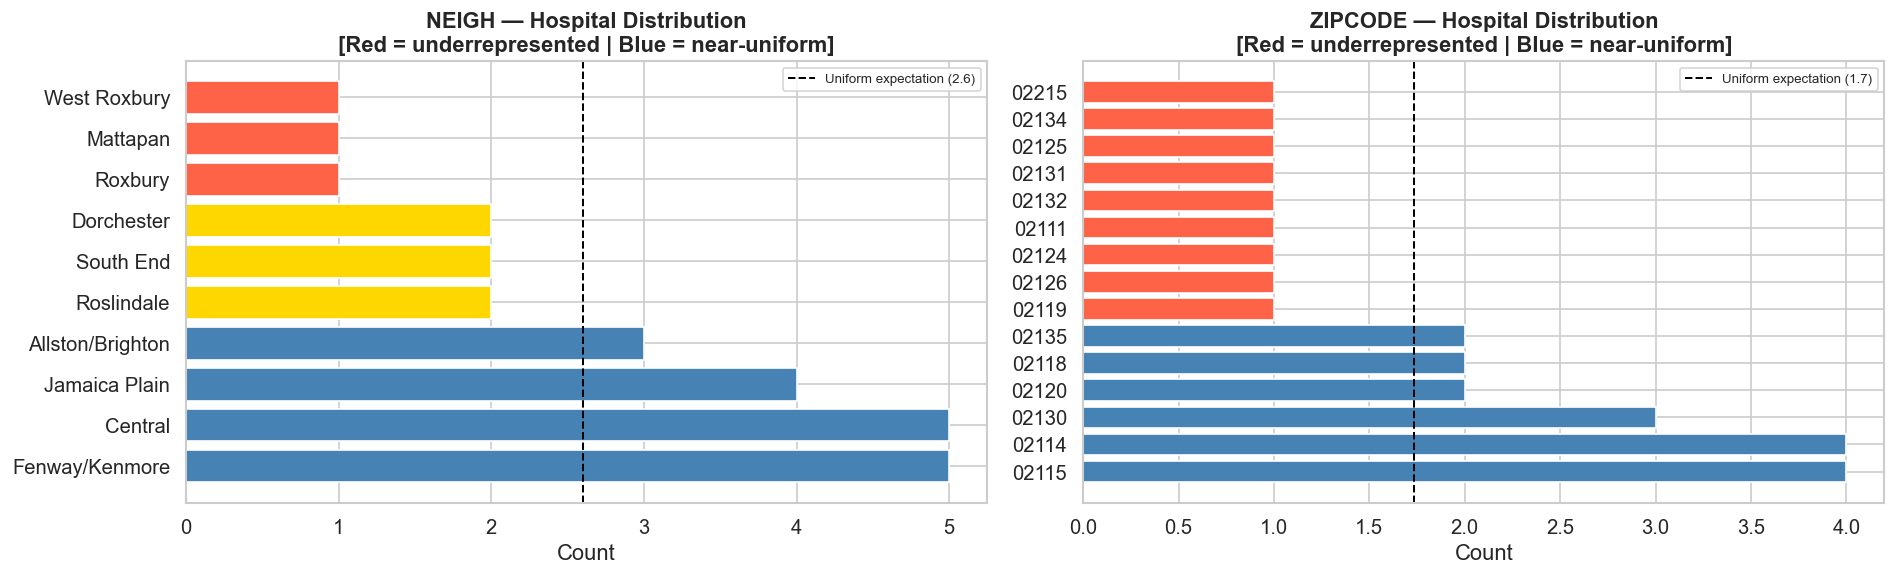

In [21]:
## 8 · Slice Imbalance Visualisation (mirrors VZ §3.2)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for ax, col in zip(axes, ["NEIGH", "ZIPCODE"]):
    vc       = df[col].value_counts(dropna=False)
    expected = len(df) / len(vc)
    colors   = [
        "tomato"    if v < expected * 0.7 else
        "gold"      if v < expected * 0.9 else
        "steelblue"
        for v in vc.values
    ]
    ax.barh(vc.index.astype(str), vc.values, color=colors, edgecolor="white")
    ax.axvline(expected, color="black", linestyle="--", linewidth=1.2,
               label=f"Uniform expectation ({expected:.1f})")
    ax.set_title(f"{col} — Hospital Distribution\n[Red = underrepresented | Blue = near-uniform]",
                 fontweight="bold")
    ax.set_xlabel("Count")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


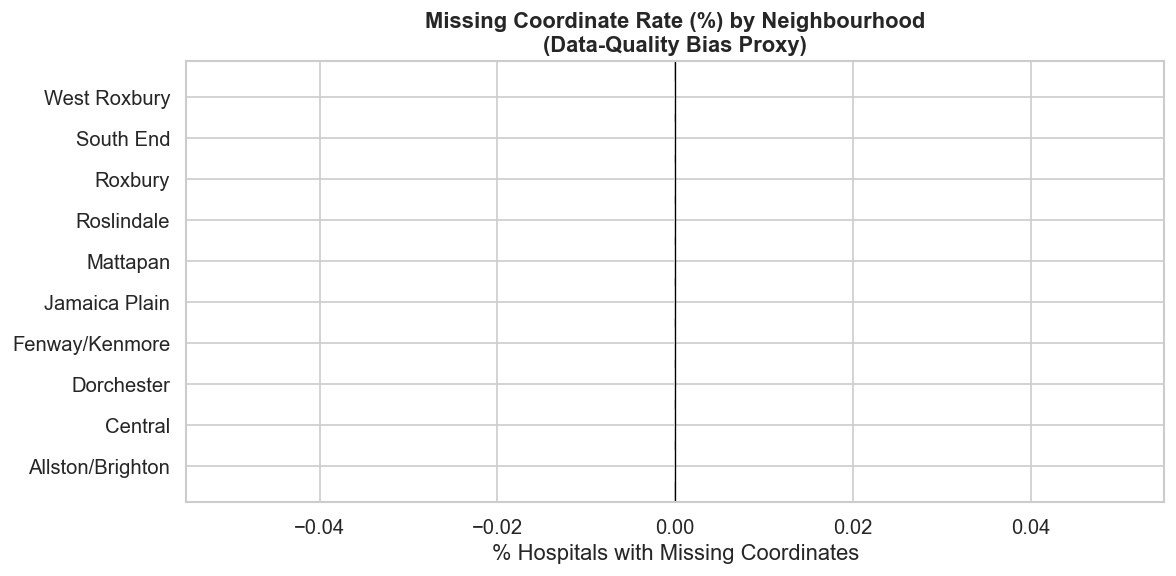


Coordinate coverage by Neighbourhood:


,located,total,coord_rate,missing,missing_pct
NEIGH,,,,,
Allston/Brighton,3,3,1.0,0,0.0
Central,5,5,1.0,0,0.0
Dorchester,2,2,1.0,0,0.0
Fenway/Kenmore,5,5,1.0,0,0.0
Jamaica Plain,4,4,1.0,0,0.0
Mattapan,1,1,1.0,0,0.0
Roslindale,2,2,1.0,0,0.0
Roxbury,1,1,1.0,0,0.0
South End,2,2,1.0,0,0.0


In [22]:
## 9 · Missing Coordinate Rate by Neighbourhood (mirrors VZ §3.3)
#
# Hospitals without coordinates are invisible to spatial planning tools —
# same data-quality bias logic as missing Lat/Long in the VZ notebook.

miss_rate = (
    df.groupby("NEIGH")["IS_LOCATED"]
      .agg(["sum", "count", "mean"])
      .rename(columns={"sum": "located", "count": "total", "mean": "coord_rate"})
      .assign(missing=lambda d: d["total"] - d["located"],
              missing_pct=lambda d: ((1 - d["coord_rate"]) * 100).round(1))
      .sort_values("missing_pct", ascending=False)
)

fig, ax = plt.subplots(figsize=(10, 5))
colors  = ["tomato" if v > 0 else "steelblue" for v in miss_rate["missing_pct"]]
ax.barh(miss_rate.index, miss_rate["missing_pct"], color=colors, edgecolor="white")
ax.axvline(0, color="black", linewidth=0.8)
ax.set_title("Missing Coordinate Rate (%) by Neighbourhood\n(Data-Quality Bias Proxy)",
             fontweight="bold")
ax.set_xlabel("% Hospitals with Missing Coordinates")
plt.tight_layout()
plt.show()

print("\nCoordinate coverage by Neighbourhood:")
display(miss_rate)

In [23]:
## 10 · SliceFinder-style Bias Detection (mirrors VZ §3.5)
#
# Flag neighbourhoods/ZIPs whose hospital count deviates > 1 std from mean.
# (z_thresh lowered to 1.0 given only 26 records — 2.0 would flag nothing)

def find_biased_slices(df, slice_col, count_col=None, z_thresh=1.0):
    vc = df[slice_col].value_counts(dropna=False).reset_index()
    vc.columns = [slice_col, "n"]
    mean_ = vc["n"].mean()
    std_  = vc["n"].std()
    vc["z_score"]     = ((vc["n"] - mean_) / std_).round(3) if std_ > 0 else 0
    vc["flagged"]     = vc["z_score"].abs() > z_thresh
    vc["deviation_%"] = ((vc["n"] - mean_) / mean_ * 100).round(1)
    return vc.sort_values("z_score", key=abs, ascending=False)

for col in ["NEIGH", "ZIPCODE"]:
    print(f"\n── SliceFinder (z_thresh=1.0): hospital count by {col} ──")
    display(find_biased_slices(df, col))



── SliceFinder (z_thresh=1.0): hospital count by NEIGH ──


,NEIGH,n,z_score,flagged,deviation_%
0,Fenway/Kenmore,5,1.521,True,92.3
1,Central,5,1.521,True,92.3
7,Roxbury,1,-1.014,True,-61.5
8,Mattapan,1,-1.014,True,-61.5
9,West Roxbury,1,-1.014,True,-61.5
2,Jamaica Plain,4,0.887,False,53.8
4,Roslindale,2,-0.380,False,-23.1
5,South End,2,-0.380,False,-23.1
6,Dorchester,2,-0.380,False,-23.1
3,Allston/Brighton,3,0.254,False,15.4



── SliceFinder (z_thresh=1.0): hospital count by ZIPCODE ──


,ZIPCODE,n,z_score,flagged,deviation_%
0,02115,4,2.061,True,130.8
1,02114,4,2.061,True,130.8
2,02130,3,1.152,True,73.1
6,02119,1,-0.667,False,-42.3
7,02126,1,-0.667,False,-42.3
8,02124,1,-0.667,False,-42.3
9,02111,1,-0.667,False,-42.3
10,02132,1,-0.667,False,-42.3
11,02131,1,-0.667,False,-42.3
12,02125,1,-0.667,False,-42.3


Mean hospitals per neighbourhood : 2.60
Flagging threshold               : 1.30  (≤ 0.5× mean)

Flagged neighbourhoods (3) — potentially under-served:


,hospital_count
NEIGH,
Roxbury,1
Mattapan,1
West Roxbury,1


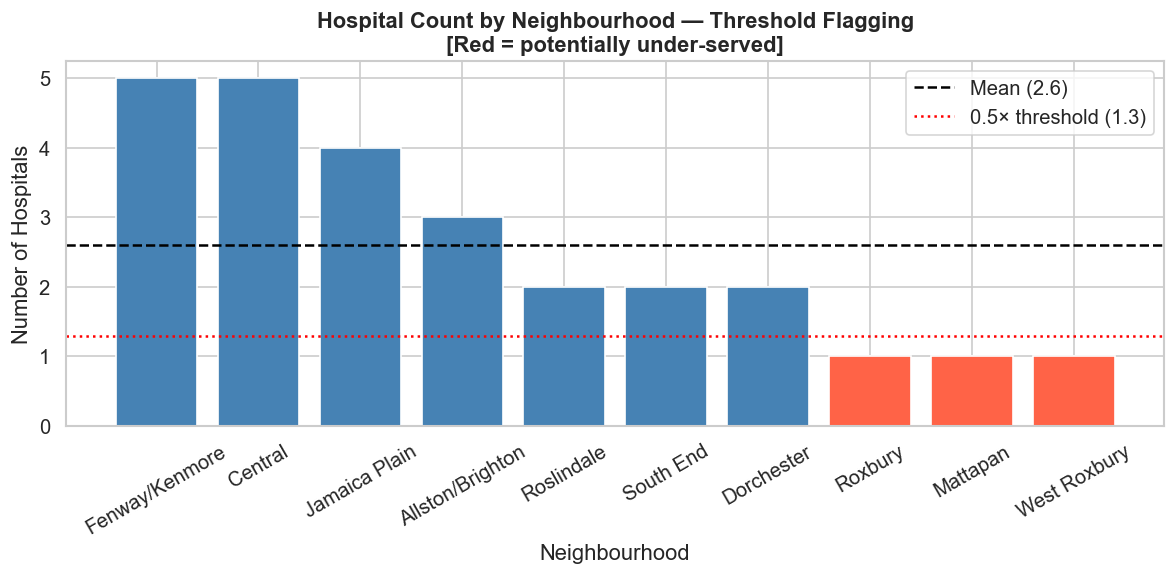

In [24]:
## 11 · Threshold Flagging — Under-served Neighbourhoods (mirrors VZ §4.2)
#
# Flag neighbourhoods with hospital count ≤ 0.5× the city-wide mean.
# These are areas with potentially limited hospital access.

neigh_counts  = df["NEIGH"].value_counts()
overall_mean  = neigh_counts.mean()
threshold     = 0.5 * overall_mean

flagged = neigh_counts[neigh_counts <= threshold]
print(f"Mean hospitals per neighbourhood : {overall_mean:.2f}")
print(f"Flagging threshold               : {threshold:.2f}  (≤ 0.5× mean)")
print(f"\nFlagged neighbourhoods ({len(flagged)}) — potentially under-served:")
display(flagged.rename("hospital_count").to_frame())

fig, ax = plt.subplots(figsize=(10, 5))
colors  = ["tomato" if v <= threshold else "steelblue" for v in neigh_counts.values]
ax.bar(neigh_counts.index, neigh_counts.values, color=colors, edgecolor="white")
ax.axhline(overall_mean, color="black", linestyle="--",
           label=f"Mean ({overall_mean:.1f})")
ax.axhline(threshold, color="red",   linestyle=":",
           label=f"0.5× threshold ({threshold:.1f})")
ax.set_title("Hospital Count by Neighbourhood — Threshold Flagging\n"
             "[Red = potentially under-served]", fontweight="bold")
ax.set_ylabel("Number of Hospitals")
ax.set_xlabel("Neighbourhood")
ax.tick_params(axis="x", rotation=30)
ax.legend()
plt.tight_layout()
plt.show()

In [25]:
## 12 · Summary Table — Full Hospital Inventory

print("\n── Full Hospital Inventory ──────────────────────────────────")
display(
    df[["NAME", "AD", "NEIGH", "ZIPCODE", "Lat", "Long", "IS_LOCATED"]]
      .sort_values("NEIGH")
      .reset_index(drop=True)
)


── Full Hospital Inventory ──────────────────────────────────


,NAME,AD,NEIGH,ZIPCODE,Lat,Long,IS_LOCATED
0,Franciscan Children's Hospital,30 WARREN ST,Allston/Brighton,02134,42.349686,-71.145444,1
1,St. Elizabeth's Hospital,736 CAMBRIDGE ST,Allston/Brighton,02135,42.349484,-71.148694,1
2,Kindred Hospital,1515 COMMONWEALTH AV,Allston/Brighton,02135,42.344524,-71.143257,1
3,Shriners Burns Institute,51 BLOSSOM ST,Central,02114,42.363078,-71.067780,1
4,Massachusetts General Hospital,55 FRUIT ST,Central,02114,42.362495,-71.070473,1
5,New England Medical Center,750 WASHINGTON ST,Central,02111,42.349919,-71.064105,1
6,Massachusetts Eye & Ear Infirmary,243 CHARLES ST,Central,02114,42.361888,-71.071597,1
7,Spaulding Rehabilitation Hospital,125 NASHUA ST,Central,02114,42.365851,-71.064181,1
8,St. Margaret's Hospital For Women,90 CUSHING AV,Dorchester,02125,42.313434,-71.063289,1
9,Carney Hospital,2100 DORCHESTER AV,Dorchester,02124,42.278793,-71.066700,1
